In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Importing the pre-processed file into the notebook

In [19]:
data_f = pd.read_csv('/kaggle/input/duration-exp/final_model_exp.csv')

Dropping unecessary columns based on feature selection and relevance

In [20]:
data_f.drop(columns=['criminal', 'act', 'Unnamed: 0'], inplace=True)

In [21]:
print(data_f.head())

                ddl_case_id  state_code  dist_code  court_no  \
0  01-01-01-201900000062017           1          1         1   
1  01-01-01-201900000082017           1          1         1   
2  01-01-01-201900000252017           1          1         1   
3  01-01-01-201900000302017           1          1         1   
4  01-01-01-201900000342017           1          1         1   

              judge_position  type_name  purpose_name  disp_name  \
0  chief judicial magistrate     1943.0        6212.0         26   
1  chief judicial magistrate     1943.0        6212.0         26   
2  chief judicial magistrate     1943.0        7136.0         26   
3  chief judicial magistrate     1943.0        6212.0         44   
4  chief judicial magistrate     1943.0         917.0         26   

  date_of_filing date_of_decision    section  number_sections_ipc  duration_f  
0     2017-01-06       2017-02-16   841964.0                  5.0          41  
1     2017-01-07       2017-01-19  1111430.0  

Removing Outliers (restricting the duration of case solved to less than about 15 years)

In [22]:
data_f = data_f[data_f['duration_f'] <= 5300]

Dividing the duration of case solved into segments of **[Within 1 year, Within 2 years, Within 3 years, Within 4 years, More than 4 years]**

In [23]:
bins = [-0.0001, 365, 365*2, 365*3, 365*4, 365*5]
group_names=['In 1 year','In 2 years','In 3 years','In 4 years','More than 4 years']
data_f['within']=pd.cut(data_f['duration_f'],bins,labels=group_names)

In [24]:
print(data_f)

                      ddl_case_id  state_code  dist_code  court_no  \
0        01-01-01-201900000062017           1          1         1   
1        01-01-01-201900000082017           1          1         1   
2        01-01-01-201900000252017           1          1         1   
3        01-01-01-201900000302017           1          1         1   
4        01-01-01-201900000342017           1          1         1   
...                           ...         ...        ...       ...   
3418619  32-01-01-213410000132018          32          1         1   
3418620  32-01-01-213410000142018          32          1         1   
3418621  32-01-01-213410000152018          32          1         1   
3418622  32-01-01-214010000092018          32          1         1   
3418623  32-01-01-214010000312018          32          1         1   

                                judge_position  type_name  purpose_name  \
0                    chief judicial magistrate     1943.0        6212.0   
1        

In [25]:
data_f.dropna(inplace=True)

Split columns into **Features** and **Target**

In [26]:
feat = pd.DataFrame(data_f.iloc[:, [1,2,3,4,5,6,7,10,11]])
targ = pd.DataFrame(data_f.iloc[:, [13]])

Recheck if the target has null values

In [27]:
targ.isnull().sum()

within    0
dtype: int64

Split the dataset into **Training and Testing** sets using **Test-Train Split**

In [28]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feat, targ, test_size = .20, random_state = 42)

Using pandas **Label Encoding** to convert string features into integers to apply **Linear Regression Model**

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

lenc = preprocessing.LabelEncoder()

X_train['state_code'] = lenc.fit_transform(X_train['state_code'])
X_train['dist_code'] = lenc.fit_transform(X_train['dist_code'])
X_train['court_no'] = lenc.fit_transform(X_train['court_no'])
X_train['judge_position'] = lenc.fit_transform(X_train['judge_position'])
X_train['type_name'] = lenc.fit_transform(X_train['type_name'])
X_train['purpose_name'] = lenc.fit_transform(X_train['purpose_name'])
X_train['disp_name'] = lenc.fit_transform(X_train['disp_name'])
X_train['section'] = lenc.fit_transform(X_train['section'])
X_train['number_sections_ipc'] = lenc.fit_transform(X_train['number_sections_ipc'])

Build a **Random Forest Classifier** with added **Class Weights** (because the data set has heavy imbalance on cases closed within 1 year)

In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=40, class_weight = 'balanced_subsample')

Training the model

In [32]:
rfc.fit(X_train[['state_code', 'dist_code', 'court_no', 'judge_position', 'type_name', 'purpose_name', 'disp_name', 'section', 'number_sections_ipc']], y_train['within'])

RandomForestClassifier(class_weight='balanced_subsample', max_depth=4,
                       n_estimators=500, random_state=40)

Encoding the Test Set

In [33]:
X_test['state_code'] = lenc.fit_transform(X_test['state_code'])
X_test['dist_code'] = lenc.fit_transform(X_test['dist_code'])
X_test['court_no'] = lenc.fit_transform(X_test['court_no'])
X_test['judge_position'] = lenc.fit_transform(X_test['judge_position'])
X_test['type_name'] = lenc.fit_transform(X_test['type_name'])
X_test['purpose_name'] = lenc.fit_transform(X_test['purpose_name'])
X_test['disp_name'] = lenc.fit_transform(X_test['disp_name'])
X_test['section'] = lenc.fit_transform(X_test['section'])
X_test['number_sections_ipc'] = lenc.fit_transform(X_test['number_sections_ipc'])

In [34]:
prediction = rfc.predict(X_test[['state_code', 'dist_code', 'court_no', 'judge_position', 'type_name', 'purpose_name', 'disp_name', 'section', 'number_sections_ipc']])

Calculating the Score for the model on the Testing Dataset

In [35]:
print(rfc.score(X_test[['state_code', 'dist_code', 'court_no', 'judge_position', 'type_name', 'purpose_name', 'disp_name', 'section', 'number_sections_ipc']], y_test['within']))

0.6020534571647957


Visualizing the **Confusion Matrix**

In [36]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test['within'], prediction))

[[394218  84351  92118  44201     13]
 [ 17413  14352  18913  10041      5]
 [  1641   1476   2968   1716      0]
 [    48     44    106    101      0]
 [     0      0      0      0      0]]


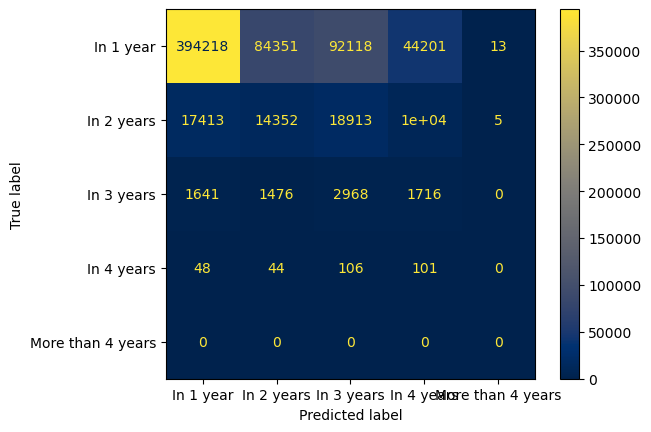

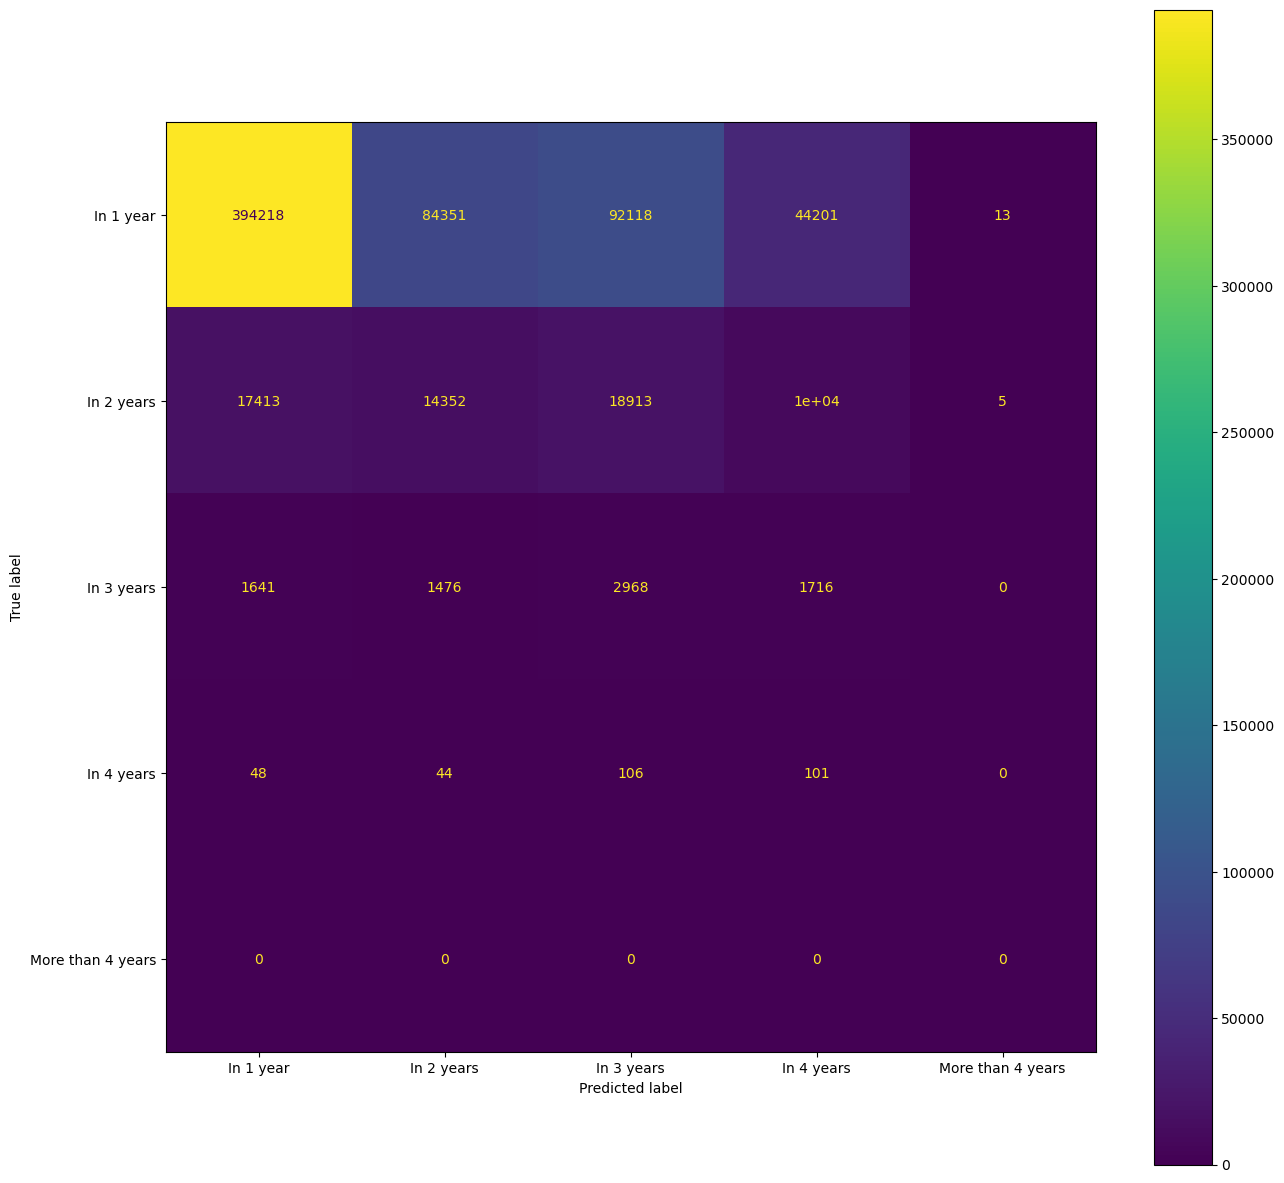

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

cmp = ConfusionMatrixDisplay.from_predictions(y_test, prediction, cmap = 'cividis')
fig, ax = plt.pyplot.subplots(figsize=(15,15))
cmp.plot(ax = ax)

plt.pyplot.savefig('matrix_f.png')

Installing **Dython** for making **catgeorical correlation matrix and heatmap**

In [52]:
pip install dython --user

^C

Note: you may need to restart the kernel to use updated packages.


Filtering required categorical variables into a new dataframe

In [53]:
data_d = data_f[['within', 'state_code', 'dist_code', 'court_no', 'judge_position', 'type_name', 'purpose_name', 'disp_name', 'section', 'number_sections_ipc']].copy()

Converting the target column's datatype from category to object

In [54]:
data_d = data_d.astype({"within":'object'})

In [55]:
data_d.dtypes

within                  object
state_code               int64
dist_code                int64
court_no                 int64
judge_position          object
type_name              float64
purpose_name           float64
disp_name                int64
section                float64
number_sections_ipc    float64
dtype: object

Visualizing the **Heatmap**

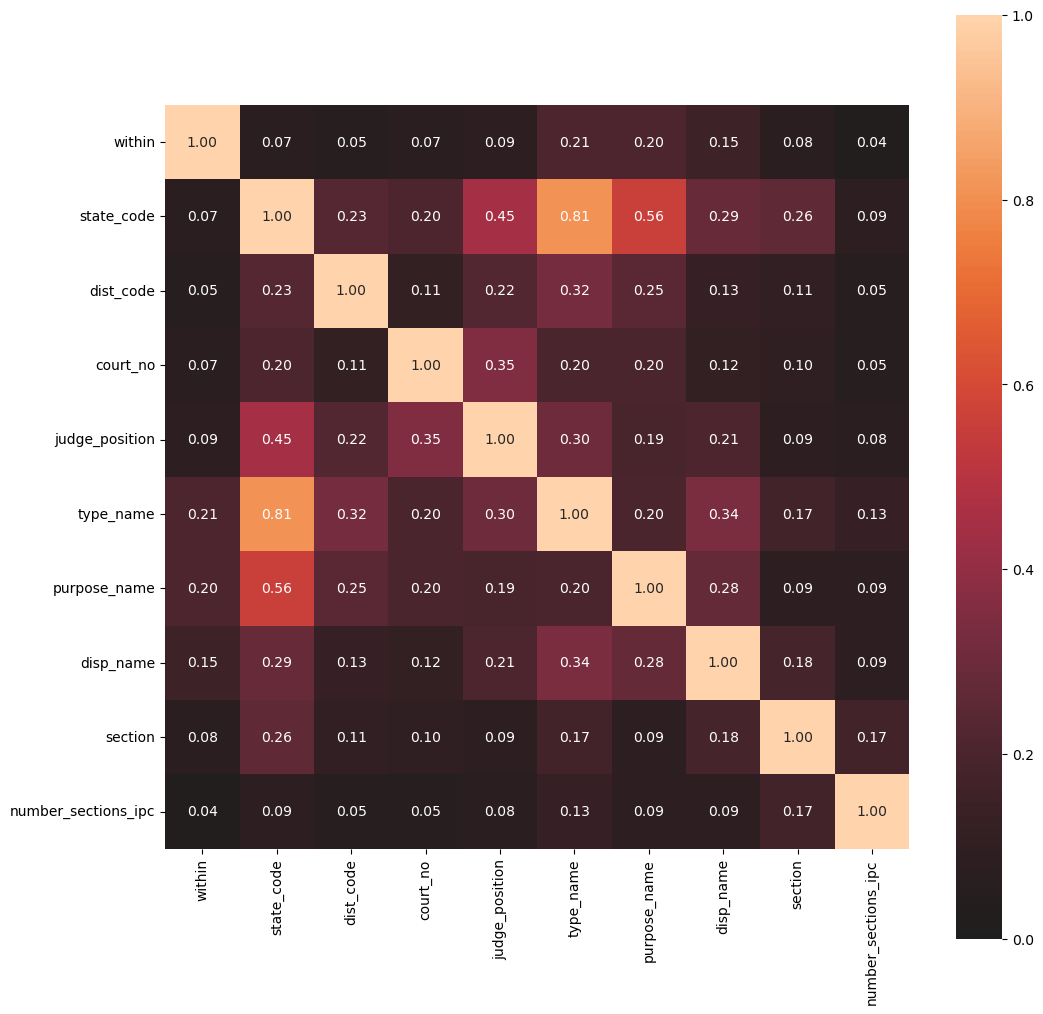

<Figure size 640x480 with 0 Axes>

In [57]:
from dython.nominal import associations
associations(data_d, nominal_columns= 'all', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson', ax=None, figsize=(12,12), annot=True, fmt='.2f', cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)
plt.pyplot.savefig('heat_map.png')